In [790]:
import pandas as pd

df = pd.read_csv('../data/cleaned.csv')
print('Shape:', df.shape)


df.head()


# %%
# Quick info and basic checks
print('\n--- Info ---')
print(df.info())
print('\n--- Describe numeric ---')
print(df.describe())
print('\nColumns:', df.columns.tolist())

Shape: (5900, 12)

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900 entries, 0 to 5899
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           5900 non-null   object 
 1   ten_san_pham  5900 non-null   object 
 2   ngay_dang     5900 non-null   object 
 3   nam_sx        5900 non-null   int64  
 4   nhien_lieu    5900 non-null   object 
 5   kieu_dang     5900 non-null   object 
 6   tinh_trang    5900 non-null   object 
 7   so_km         5900 non-null   float64
 8   hop_so        5900 non-null   object 
 9   xuat_xu       5900 non-null   object 
 10  dia_diem      5900 non-null   object 
 11  gia_ban       5900 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 553.2+ KB
None

--- Describe numeric ---
            nam_sx          so_km      gia_ban
count  5900.000000    5900.000000  5900.000000
mean   2019.524746   54672.868644     0.839832
std       4.822733   51

# Preprocessing

## 1. Loại bỏ cột không cần thiết

In [791]:
data = df.copy()
data = data.drop(columns=['url', 'ten_san_pham'])

## 2. Extract city từ dia_diem


In [792]:
mapper = {
    'Hà Nội': 1,
    'Tp.HCM': 2,
    'Đà Nẵng': 3,
    'Hải Phòng': 4,
    'Bắc Ninh': 5,
    'Thanh Hóa': 6,
    'Nghệ An': 7,
    'Bình Dương': 8
}

def city_mapping(s: str):
    for key in mapper:
        if s.__contains__(key):
            return mapper[key]
    return 0

data['city'] = data['dia_diem'].apply(city_mapping)

## 3. Parse ngay_dang -> post_year, post_month (hỗ trợ dd/mm/yyyy hoặc yyyy-mm-dd)

In [793]:
import numpy as np
import re

def parse_post_year_month(s):
    if pd.isna(s): return (np.nan, np.nan)
    st = str(s).strip()
    m = re.search(r'(\d{1,2})[/\\-](\d{1,2})[/\\-](\d{4})', st)
    if m:
        return int(m.group(3)), int(m.group(2))
    m2 = re.search(r'(\d{4})[-/](\d{1,2})[-/](\d{1,2})', st)
    if m2:
        return int(m2.group(1)), int(m2.group(2))
    return (np.nan, np.nan)

parsed = data['ngay_dang'].apply(parse_post_year_month)
data['post_year'] = parsed.apply(lambda x: x[0] if isinstance(x, tuple) else np.nan)
data['post_month'] = parsed.apply(lambda x: x[1] if isinstance(x, tuple) else np.nan)

## 4. Tạo feature 'age' = post_year - nam_sx (nếu post_year missing, fallback dùng 2025)

In [794]:
def compute_age(row):
    nsx = row.get('nam_sx', np.nan)
    py = row.get('post_year', np.nan)
    try:
        if pd.isna(nsx): return np.nan
        if pd.isna(py): return int(2025 - int(nsx))
        return int(py) - int(nsx)
    except:
        return np.nan

data['age'] = data.apply(compute_age, axis=1)

## 5. Categorical columns

In [795]:
cat_cols = ['nhien_lieu', 'kieu_dang', 'tinh_trang', 'hop_so', 'xuat_xu', 'city']

## 6. One-hot encode categorical

In [796]:
X_cat = pd.get_dummies(data[cat_cols], columns=cat_cols, dtype=float)

## 7. Numeric features to use

In [797]:
num_cols = ['so_km', 'age', 'nam_sx', 'post_month']
X_num = data[num_cols].copy()

## 8. Kết hợp features

In [798]:
X = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)

## 9. Target y: numeric

In [799]:
y = pd.to_numeric(data.gia_ban, errors='coerce').values

## 10. Thông báo shape & một số kiểm tra

In [800]:
print("Processed X shape:", X.shape)
print("Sample feature columns:", X.columns.tolist())
print("y shape:", y.shape)
display(pd.DataFrame({'feature_head': X.columns.tolist()[:10]}))
# Optionally show few rows of processed X,y
display(X.head())
display(pd.Series(y).head())


Processed X shape: (5900, 38)
Sample feature columns: ['so_km', 'age', 'nam_sx', 'post_month', 'nhien_lieu_Hybrid', 'nhien_lieu_Loại khác', 'nhien_lieu_Máy dầu', 'nhien_lieu_Máy xăng', 'nhien_lieu_Điện', 'kieu_dang_Bán tải', 'kieu_dang_Convertible', 'kieu_dang_Coupe', 'kieu_dang_Crossover', 'kieu_dang_Hatchback', 'kieu_dang_MPV', 'kieu_dang_Minibus', 'kieu_dang_SUV', 'kieu_dang_Sedan', 'kieu_dang_Special Purpose', 'kieu_dang_Sport Car', 'kieu_dang_Van/Minivan', 'kieu_dang_Wagon', 'kieu_dang_Xe tải', 'tinh_trang_Xe cũ', 'tinh_trang_Xe mới', 'hop_so_Số hỗn hợp', 'hop_so_Số sàn', 'hop_so_Số tự động', 'xuat_xu_Nhập khẩu', 'xuat_xu_Trong nước', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8']
y shape: (5900,)


,feature_head
0,so_km
1,age
2,nam_sx
3,post_month
4,nhien_lieu_Hybrid
5,nhien_lieu_Loại khác
6,nhien_lieu_Máy dầu
7,nhien_lieu_Máy xăng
8,nhien_lieu_Điện
9,kieu_dang_Bán tải


,so_km,age,nam_sx,post_month,nhien_lieu_Hybrid,nhien_lieu_Loại khác,nhien_lieu_Máy dầu,nhien_lieu_Máy xăng,nhien_lieu_Điện,kieu_dang_Bán tải,...,xuat_xu_Nhập khẩu,xuat_xu_Trong nước,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8
0,0.0,0,2025,8,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,4,2021,10,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1,2024,8,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,164969.0,3,2022,10,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,16000.0,1,2024,10,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    1.569
1    0.595
2    0.700
3    0.168
4    0.415
dtype: float64

# Split data

In [801]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numeric features (Scaler and transform)

In [802]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on train then transform train/val/test
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

y_scaler = StandardScaler()

y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

# Implement Linear Regression

In [803]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Linear(X_train.shape[1], 1)

criterion = nn.MSELoss() # Mean Squared Error
optimizer = optim.SGD(model.parameters(), lr=0.05)

epochs = 2000
train_losses = []

In [804]:
X_train_tensor = torch.tensor(X_train.astype(float).values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.astype(float).values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [805]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    print(f"Epoch {epoch+1:02d} | Train Loss: {loss.item():.4f}")

Epoch 01 | Train Loss: 0.9879
Epoch 02 | Train Loss: 0.9362
Epoch 03 | Train Loss: 0.9090
Epoch 04 | Train Loss: 0.8934
Epoch 05 | Train Loss: 0.8835
Epoch 06 | Train Loss: 0.8767
Epoch 07 | Train Loss: 0.8717
Epoch 08 | Train Loss: 0.8677
Epoch 09 | Train Loss: 0.8644
Epoch 10 | Train Loss: 0.8615
Epoch 11 | Train Loss: 0.8590
Epoch 12 | Train Loss: 0.8568
Epoch 13 | Train Loss: 0.8548
Epoch 14 | Train Loss: 0.8529
Epoch 15 | Train Loss: 0.8512
Epoch 16 | Train Loss: 0.8497
Epoch 17 | Train Loss: 0.8482
Epoch 18 | Train Loss: 0.8468
Epoch 19 | Train Loss: 0.8456
Epoch 20 | Train Loss: 0.8444
Epoch 21 | Train Loss: 0.8432
Epoch 22 | Train Loss: 0.8422
Epoch 23 | Train Loss: 0.8412
Epoch 24 | Train Loss: 0.8402
Epoch 25 | Train Loss: 0.8393
Epoch 26 | Train Loss: 0.8385
Epoch 27 | Train Loss: 0.8376
Epoch 28 | Train Loss: 0.8368
Epoch 29 | Train Loss: 0.8361
Epoch 30 | Train Loss: 0.8354
Epoch 31 | Train Loss: 0.8347
Epoch 32 | Train Loss: 0.8340
Epoch 33 | Train Loss: 0.8334
Epoch 34 |

In [806]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def print_metrics(y_true, y_pred, label=''):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} -> MSE: {mse:.6f} | MAE: {mae:.6f} | R2: {r2:.6f}")
    

model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    y_test_pred = y_test_pred.detach().numpy()

print_metrics(y_test, y_test_pred)

 -> MSE: 0.757033 | MAE: 0.401403 | R2: 0.272204


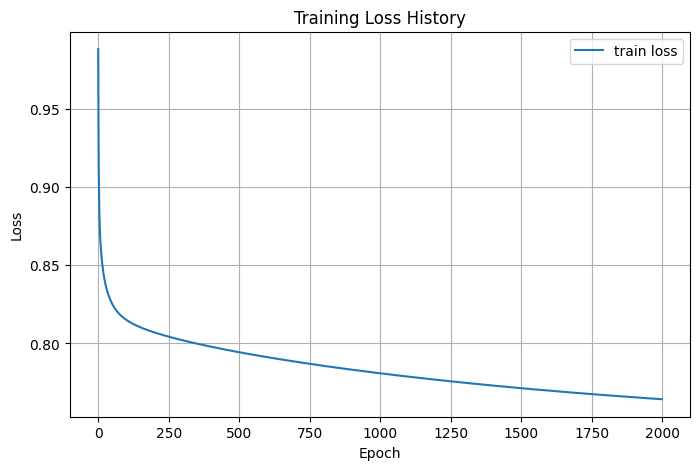

In [807]:
# 8) Plot training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid(True)
plt.legend()
plt.show()
